# CIFAR-10 이미지 생성하기

In [1]:
import os
import glob
import time

import PIL
import imageio.v2 as imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# Step1. 작업환경 구성하기

In [2]:
def make_dir(dir_path):
    if os.path.exists(dir_path):
        print(dir_path,'is already existed')
    else:
        os.makedirs(dir_path)

In [3]:
make_dir('.\\cifar10\\generated_samples')
make_dir('.\\cifar10\\training_checkpoints')
make_dir('.\\cifar10\\training_history')

# Step2. 데이터셋 구성하기

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.<br>
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.<br>
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.<br>

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


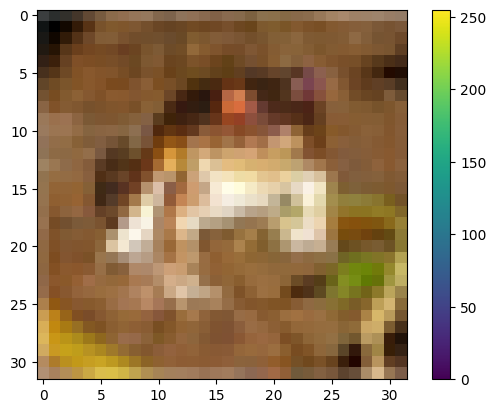

In [6]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_x.shape

(50000, 32, 32, 3)

In [9]:
train_x[0,:,:,0]

array([[-0.5372549 , -0.6627451 , -0.60784314, ...,  0.23921569,
         0.19215686,  0.16078431],
       [-0.8745098 , -1.        , -0.85882353, ..., -0.03529412,
        -0.06666667, -0.04313725],
       [-0.80392157, -0.8745098 , -0.61568627, ..., -0.0745098 ,
        -0.05882353, -0.14509804],
       ...,
       [ 0.63137255,  0.57647059,  0.55294118, ...,  0.25490196,
        -0.56078431, -0.58431373],
       [ 0.41176471,  0.35686275,  0.45882353, ...,  0.44313725,
        -0.23921569, -0.34901961],
       [ 0.38823529,  0.31764706,  0.40392157, ...,  0.69411765,
         0.18431373, -0.03529412]])

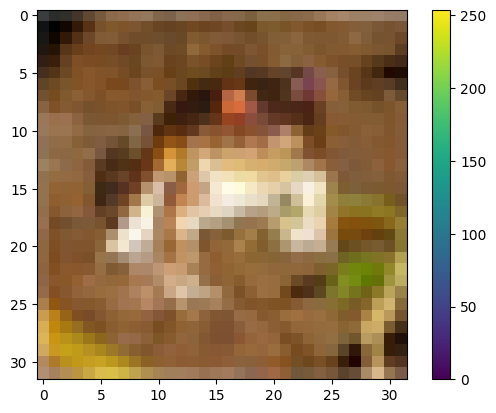

In [10]:
# -1~1 을 원래의 이미지로 복원시켜서 화면에 보여줍니다
plt.imshow(((train_x[0]*127.5)+127).astype(np.uint8))
plt.colorbar()
plt.show()

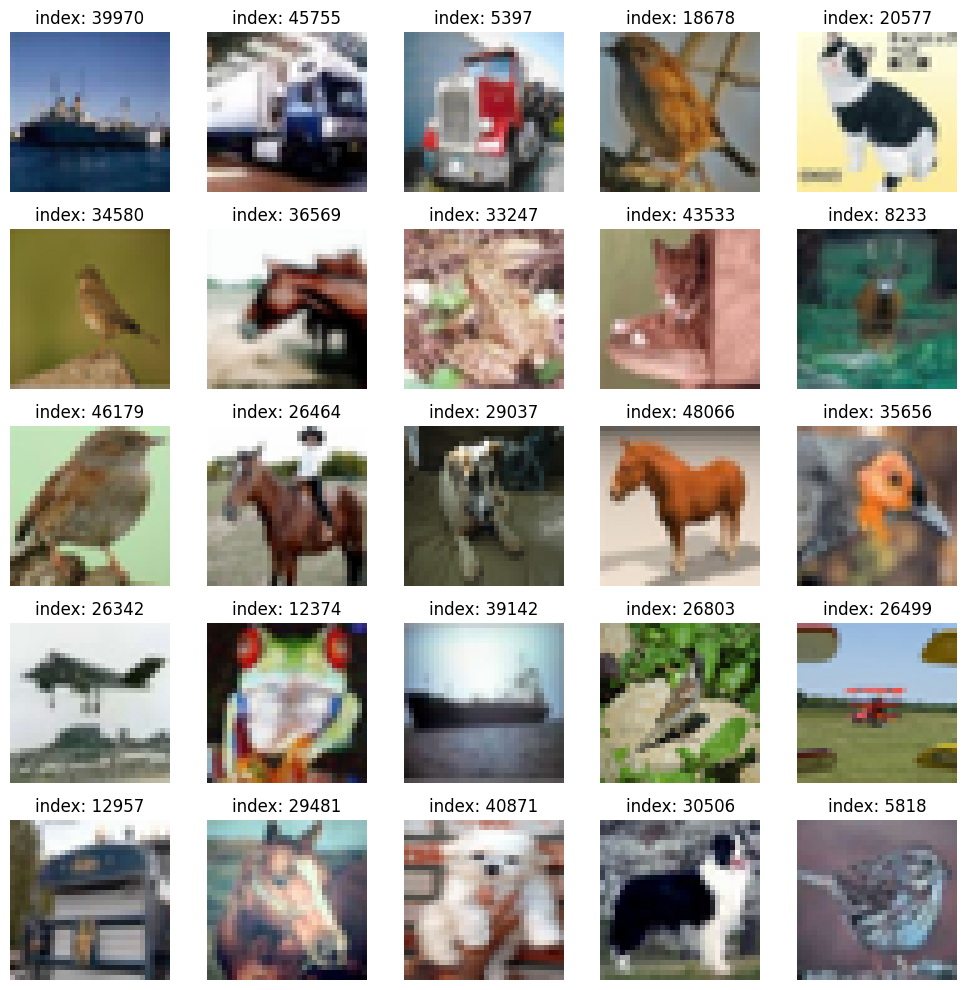

In [11]:
plt.figure(figsize=(10, 10))
import numpy as np
random_idx = np.random.choice(range(50000), 25, replace=False)

for i in range(25):
    plt.subplot(5, 5, i+1)
    
    plt.title(f'index: {random_idx[i]}')
    plt.imshow(((train_x[random_idx[i]]*127.5)+127).astype(np.uint8))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

In [12]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 3. 생성자 모델 구현하기
---
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.<br>
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.<br>
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.<br>

In [13]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [14]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [15]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1543771 ,  0.6274822 , -1.4034309 , -0.12190767,  1.6006588 ,
        -1.1940775 ,  1.187573  ,  0.3707221 ,  0.32841825,  1.2699088 ,
        -0.08984604,  0.98646957, -0.67038965,  1.3324122 ,  0.02395263,
        -1.6542593 ,  1.3742346 ,  0.24957553, -1.1005287 , -2.3321261 ,
         2.0681562 , -1.7598791 , -0.61647743,  0.6040368 ,  1.1130358 ,
         1.3766906 , -1.2167736 , -0.7906475 ,  0.72944266,  0.17589544,
        -1.7191974 , -1.8091809 , -1.3226444 , -0.8946715 , -0.24717501,
         0.20133942,  1.5910084 , -0.17563605,  0.23474777, -0.2464154 ,
         0.89249843, -0.7843899 , -1.2252345 , -0.18019532,  1.9838806 ,
        -0.06554258, -0.15178363,  0.73724735, -0.7960812 ,  0.31950182,
         1.0503747 ,  1.2851666 ,  0.15613575, -0.1274368 ,  2.0650377 ,
         0.18212716, -0.15740944, -1.8632431 , -0.06823509,  0.8134597 ,
         0.63253534, -0.7541332 , -0.03990747, -0.13890639,  0.9775316 ,
 

In [16]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [17]:
generated_image[0, :, :, :].shape

TensorShape([32, 32, 3])

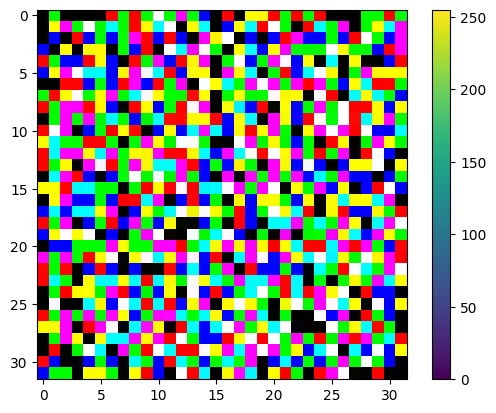

In [18]:
out = generated_image.numpy()
plt.imshow((out[0,:,:,:]*255).astype(np.uint8))
plt.colorbar()
plt.show()

# STEP 4. 판별자 모델 구현하기
---
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.<br>
- 위 STEP 3에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.<br>

In [19]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [20]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [21]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00190685]], dtype=float32)>

# STEP 5. 손실함수와 최적화 함수 구현하기
---
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.<br>
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.<br>
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.<br>

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 6. 훈련과정 상세 기능 구현하기
---
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.<br>
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.<br>
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.<br>
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.<br>

In [28]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [29]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        out = predictions[i,:,:,:].numpy()
        plt.imshow((out[:,:,:]*255).astype(np.uint8))
        plt.axis('off')
   
    plt.savefig('.\\cifar10\\generated_samples\\sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

    plt.show()

In [30]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('.\\cifar10\\training_history\\train_history_{:04d}.png'.format(epoch))
    plt.show()

In [31]:
checkpoint_dir = '.\\cifar10\\training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. 학습 과정 진행하기
---
- 위 STEP 6에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [32]:
def train(dataset, start_iter_idx, epochs, save_every):
    print('---- start_iter_idx=',start_iter_idx,' stop_iter_idx=',epochs,' ----')
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(start_iter_idx, epochs, 1):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

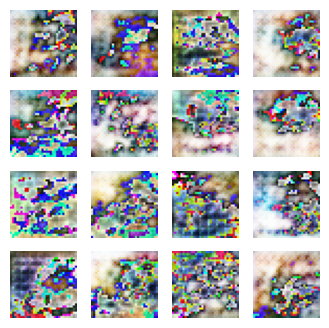

Time for training : 1493 sec


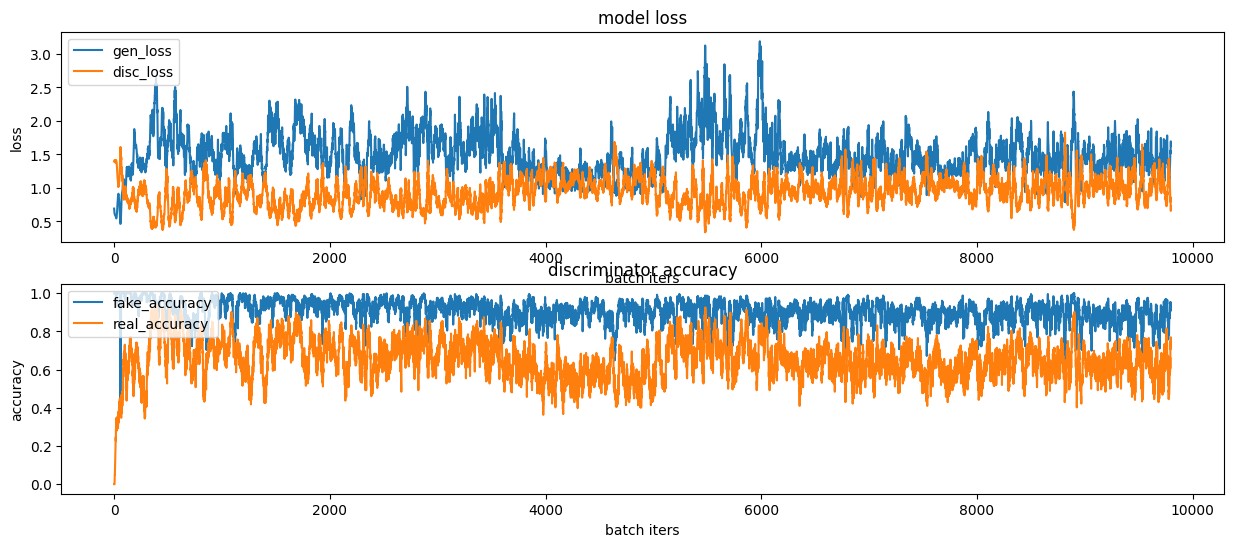

CPU times: total: 25min 5s
Wall time: 24min 54s


In [33]:
%%time
EPOCHS = 50
start_iter_idx = 0
save_every = 5

import re

checkpoint_dir = '.\\cifar10\\training_checkpoints'
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
if latest is not None:
    start_iter_idx = int(re.match(r'.*.ckpt-(\d+)', latest).group(1))
    start_iter_idx = start_iter_idx*save_every
    checkpoint.restore(latest)
    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

train(train_dataset,start_iter_idx, EPOCHS, save_every)

In [34]:
anim_file = '.\\cifar10\\cifar10-dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('.\\cifar10\\generated_samples\\sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# STEP 8. (optional) GAN 훈련 과정 개선하기

- STEP 7을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점

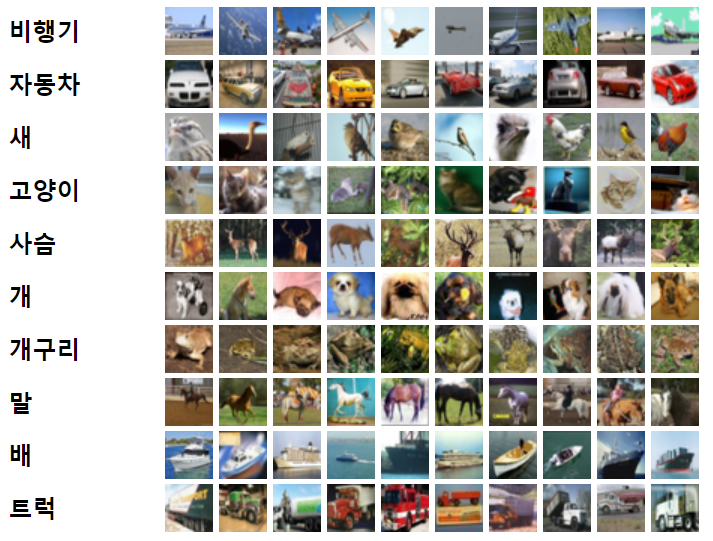<br>
- cifar10 은 10개의 분류 마다 x 5000개의 이미지가 존재하므로 너무 많은 형상에 대해서 <br>
일관적인 1개의 특징을 묘사하는 것은 어렵기 때문에 generator가 제대로 이미지를 생성해 내지 못하고 있는 문제가 존재합니다<br>
- STEP7의 마지막 그래프에서 보여지는 것과 같이 generator의 loss가 discriminator의 loss보다 높게 형성되어 있는 것도 같은 맥락으로 보입니다<br>
- 이를 해결하기 위해서 class=7(말) 이미지 5000장에 대해서 만 처리하도록 한다면 좀더 개선된 이미지 생성 결과를 얻을 것으로 보입니다<br>

- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)

In [65]:
cifar10 = tf.keras.datasets.cifar10
(train_x2, train_y2), (test_x2, test_y2) = cifar10.load_data()

In [66]:
def get_cifar10_class_data(class_num,train_x,train_y,test_x,test_y):
    # 2차원인 경우 np.where에서 제대로 얻어오지 못하므로 1차원으로 펼친다
    train_y_flat =train_y.flatten()
    test_y_flat =test_y.flatten()
    # np.where는 (array(),) 형태의 튜플결과를 리턴하므로 array, 로 array만 저장함
    train_idx_list, = np.where(train_y_flat == class_num) 
    test_idx_list, = np.where(test_y_flat == class_num)
    # (axis=0으로 설정하여 해당 index 행만 뽑아옵니다
    train_idx = np.take(train_x, train_idx_list, axis=0)
    test_idx = np.take(test_x, test_idx_list, axis=0)
    # train_idx 데이터와 test_idx 데이터를 합쳐서 6000 개 만든다
    return np.concatenate([train_idx, test_idx])

In [67]:
train_class_2 = get_cifar10_class_data(2,train_x2,train_y2,test_x2,test_y2)
train_class_7 = get_cifar10_class_data(7,train_x2,train_y2,test_x2,test_y2)

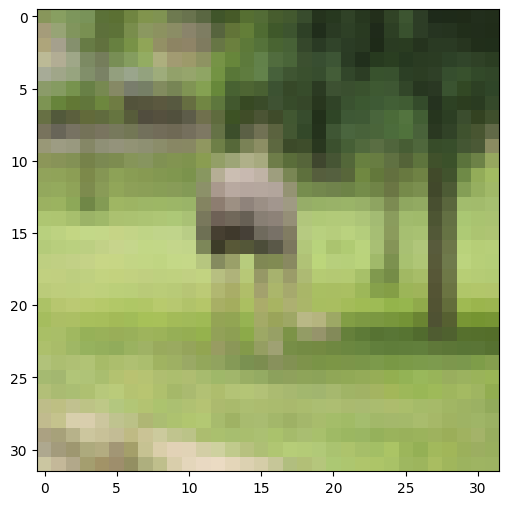

In [68]:
plt.imshow(train_class_2[5999])
plt.show()

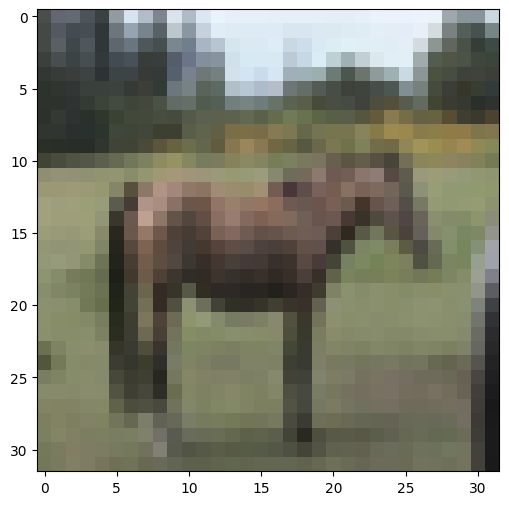

In [69]:
plt.imshow(train_class_7[5999])
plt.show()

In [70]:
# 이미지를 [-1, 1]로 정규화합니다.
train_class_2 = (train_class_2 - 127.5) / 127.5
train_class_7 = (train_class_7 - 127.5) / 127.5 

In [71]:
# train_dataset_xx 생성
BUFFER_SIZE = 6000
BATCH_SIZE = 200
train_dataset_2 = tf.data.Dataset.from_tensor_slices(train_class_2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset_7 = tf.data.Dataset.from_tensor_slices(train_class_7).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [72]:
import re
class DCGAN():
    def __init__(self,generator_model,
                 generator_model_optimizer,
                 generator_model_loss,
                 discriminator_model,
                 discriminator_model_optimizer,
                 discriminator_model_loss,
                 discriminator_model_accuracy,
                 canvas,
                 save_dir):
        
        self.plt = canvas
        
        self.generator=generator_model
        self.generator_optimizer=generator_model_optimizer
        self.generator_loss = generator_model_loss
        
        self.discriminator=discriminator_model
        self.discriminator_optimizer=discriminator_model_optimizer
        self.discriminator_loss=discriminator_model_loss
        self.discriminator_accuracy=discriminator_model_accuracy

        self.samples_dir = os.path.join(save_dir,'generated_samples')
        self.checkpoint_dir = os.path.join(save_dir,'training_checkpoints')
        self.history_dir = os.path.join(save_dir,'training_history')
        
        self.__make_dir(self.samples_dir)
        self.__make_dir(self.checkpoint_dir)
        self.__make_dir(self.history_dir)
        
        self.checkpoint = self.__make_checkpoint(self.checkpoint_dir)
    
    def __make_dir(self,dir_path):
        if os.path.exists(dir_path):
            print(dir_path,'is already existed')
        else:
            os.makedirs(dir_path)

    def __make_checkpoint(self,checkpoint_dir):
        return tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)
    
    def __generate_and_save_images(self, model, epoch, it, sample_seeds):

        predictions = model(sample_seeds, training=False)
        fig = self.plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            self.plt.subplot(4, 4, i+1)
            out = predictions[i,:,:,:].numpy()
            self.plt.imshow((out[:,:,:]*255).astype(np.uint8))
            self.plt.axis('off')

        path = os.path.join(self.samples_dir,'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
        self.plt.savefig(path)
        self.plt.show()
        
    def __draw_train_history(self, history, epoch):
        # summarize history for loss  
        self.plt.subplot(211)  
        self.plt.plot(history['gen_loss'])  
        self.plt.plot(history['disc_loss'])  
        self.plt.title('model loss')  
        self.plt.ylabel('loss')  
        self.plt.xlabel('batch iters')  
        self.plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

        # summarize history for accuracy  
        self.plt.subplot(212)  
        self.plt.plot(history['fake_accuracy'])  
        self.plt.plot(history['real_accuracy'])  
        self.plt.title('discriminator accuracy')  
        self.plt.ylabel('accuracy')  
        self.plt.xlabel('batch iters')  
        self.plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

        # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
        path = os.path.join(self.history_dir,'train_history_{:04d}.png'.format(epoch))
        self.plt.savefig(path)
        self.plt.show()
    
    @tf.function
    def __train_step(self,images):  #(1) 입력데이터
        noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
            generated_images = self.generator(noise, training=True)  #(4) generated_images 생성

            #(5) discriminator 판별
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            #(6) loss 계산
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            #(7) accuracy 계산
            real_accuracy, fake_accuracy = self.discriminator_accuracy(real_output, fake_output) 

        #(8) gradient 계산
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        #(9) 모델 학습
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

    def fit(self,dataset, epochs, save_every):
        latest = tf.train.latest_checkpoint(self.checkpoint_dir)
        start_iter_idx=0
    
        if latest is not None:
            print(latest)
            start_iter_idx = int(re.match(r'.*.ckpt-(\d+)', latest).group(1))
            start_iter_idx = start_iter_idx*save_every
            self.checkpoint.restore(latest)
            self.generator = self.checkpoint.generator
            self.discriminator = self.checkpoint.discriminator

        self.__train(dataset,start_iter_idx, epochs, save_every)

    def __train(self, dataset, start_iter_idx, epochs, save_every):
        print('---- start_iter_idx=',start_iter_idx,' stop_iter_idx=',epochs,' ----')
        start = time.time()
        history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

        for epoch in range(start_iter_idx, epochs, 1):
            epoch_start = time.time()
            for it, image_batch in enumerate(dataset):
                gen_loss, disc_loss, real_accuracy, fake_accuracy = self.__train_step(image_batch)
                history['gen_loss'].append(gen_loss)
                history['disc_loss'].append(disc_loss)
                history['real_accuracy'].append(real_accuracy)
                history['fake_accuracy'].append(fake_accuracy)

                if it % 50 == 0:
                    display.clear_output(wait=True)
                    self.__generate_and_save_images(self.generator, epoch+1, it+1, seed)
                    print('Epoch {} | iter {}'.format(epoch+1, it+1))
                    print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

            if (epoch + 1) % save_every == 0:
                prefix = os.path.join(self.checkpoint_dir, "ckpt")
                self.checkpoint.save(file_prefix=prefix)

            display.clear_output(wait=True)
            self.__generate_and_save_images(self.generator, epochs, it, seed)
            print('Time for training : {} sec'.format(int(time.time()-start)))
            self.__draw_train_history(history, epoch)

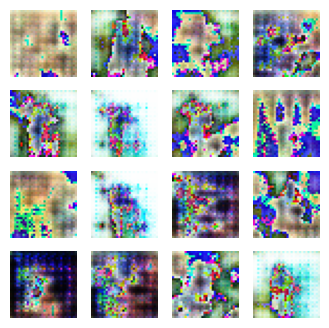

Time for training : 264 sec


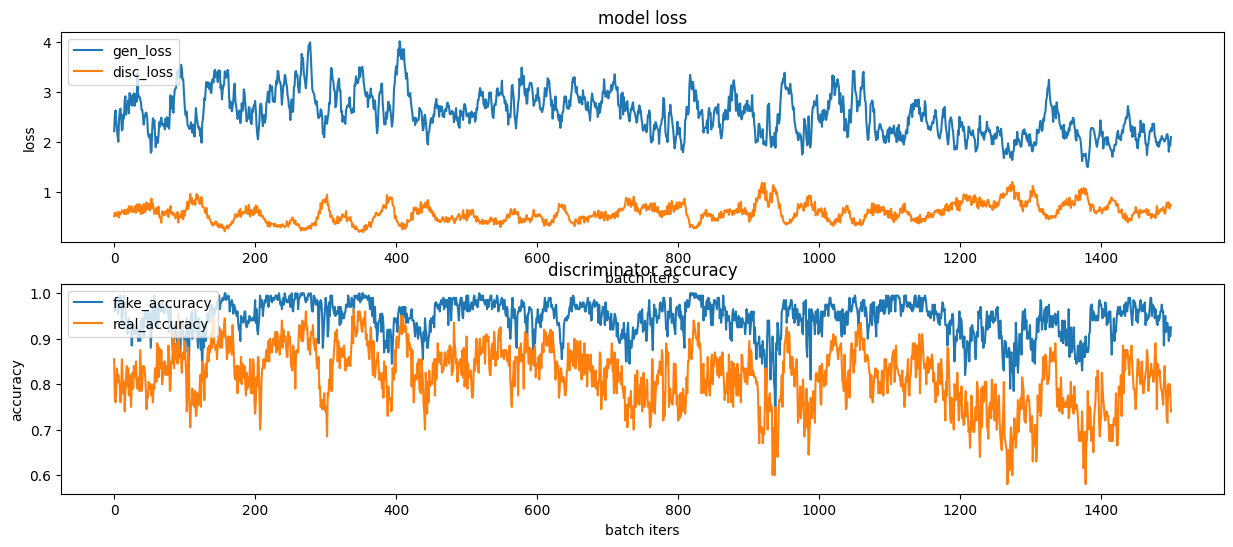

In [74]:
generator_2 = make_generator_model()
discriminator_2 = make_discriminator_model()

dcgan_2 = DCGAN(generator_2,
                 generator_optimizer,
                 generator_loss,
                 discriminator_2,
                 discriminator_optimizer,
                 discriminator_loss,
                 discriminator_accuracy,
                 plt,
                 save_dir='.\\cifar10_2')

dcgan_2.fit(dataset=train_dataset_2, epochs=100, save_every=1)

In [ ]:
generator_7 = make_generator_model()
discriminator_7 = make_discriminator_model()

dcgan_7 = DCGAN(generator_7,
                 generator_optimizer,
                 generator_loss,
                 discriminator_7,
                 discriminator_optimizer,
                 discriminator_loss,
                 discriminator_accuracy,
                 plt,
                 save_dir='.\\cifar10_7')

dcgan_7.fit(dataset=train_dataset_7, epochs=50, save_every=1)